In [1]:
import gc
import os
import string

import matplotlib.pyplot as plt
from jupyterthemes import jtplot

import torch
import numpy as np
from torch import nn
from torch.nn import functional as F
from torch import optim
from torchinfo import summary

from collections import namedtuple
import PyPDF3

In [2]:
jtplot.style("gruvboxd")

In [3]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [4]:
device

device(type='cuda')

In [5]:
SEED = 42

if device == "cuda":
    torch.cuda.manual_seed(SEED)
else:
    torch.manual_seed(SEED)

In [6]:
DATA_DIR = os.getcwd().replace('notebooks', 'data')

with open(os.path.join(DATA_DIR, 'anna.txt'), 'r') as file:
    text = file.read()

In [7]:
text[:120]

'Chapter 1\n\n\nHappy families are all alike; every unhappy family is unhappy in its own\nway.\n\nEverything was in confusion i'

In [8]:
unique_chars = list(set(text))

In [9]:
len(unique_chars)

83

In [10]:
unique_chars

['"',
 'L',
 'Y',
 'm',
 '7',
 '?',
 'C',
 'G',
 'l',
 'c',
 'u',
 ' ',
 'd',
 'U',
 '5',
 'k',
 'W',
 'b',
 'N',
 '/',
 '4',
 'p',
 't',
 '.',
 'r',
 's',
 '-',
 '2',
 '6',
 '(',
 'F',
 '@',
 '\n',
 'I',
 'y',
 'w',
 ':',
 'x',
 'K',
 'j',
 'M',
 '0',
 '$',
 '`',
 '&',
 'V',
 'H',
 'o',
 'v',
 ';',
 'Q',
 "'",
 '*',
 '1',
 'f',
 'a',
 'X',
 '!',
 'i',
 'D',
 '9',
 'z',
 '3',
 'P',
 'E',
 'A',
 '%',
 'R',
 'Z',
 'h',
 ',',
 'J',
 'O',
 'T',
 'g',
 'n',
 'e',
 '_',
 ')',
 'q',
 'B',
 'S',
 '8']

In [11]:
chars2int = {char : unique_chars.index(char) for char in unique_chars}
int2char = {v : k for (k, v) in chars2int.items()}

In [12]:
def encode_text(text, unique_chars = None, extend = False):
    result_tuple = namedtuple('results', ['encoded_text', 'unique_char', 'int2char', 'char2int'])
    
    if unique_chars is None:
        unique_chars = list(set(text))
    else:
        if extend:
            unique_chars.extend(list('#[]{}+-*=!'))
        
    char2int = {char : unique_chars.index(char) for char in unique_chars}
    int2char = {v : k for (k, v) in char2int.items()}
    
    encoded_text = np.array(list(map(lambda x: char2int[x], list(text))))
    
    return result_tuple(encoded_text, unique_chars, int2char, char2int)

In [13]:
train_frac = 0.8
text, val_text = text[:int(len(text)*train_frac)], text[int(len(text)*(train_frac)):]

In [14]:
encoded_text, unique_chars, int2char, char2int = encode_text(text, unique_chars)

In [15]:
def one_hot_convert(arr, n_labels):
    nrows = arr.size
    array = np.zeros(shape = [nrows, n_labels])
    array[np.arange(array.shape[0]), arr.flatten()] = 1.
    
    return array

In [16]:
one_hot_convert(np.array([[1, 2, 3, 5]]), 10)

array([[0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 0.]])

In [17]:
batch_size = 32
seq_length = 16

In [18]:
numel_seq = batch_size * seq_length

In [19]:
numel_seq

512

In [20]:
encoded_text.shape[0]/numel_seq

3101.91015625

In [21]:
def batch_sequence(arr, batch_size, seq_length):
    numel_seq = batch_size * seq_length
    num_batches = arr.size // numel_seq
    
    arr = arr[: num_batches * numel_seq].reshape(batch_size, -1)
    #print(arr.shape)
    
    batched_data = [(arr[:, n : n + seq_length], arr[:, n + 1 : n + 1 + seq_length])
                    for n in range(0, arr.shape[1], seq_length)]
    
    ### Finalize final array size
    batched_data[-1] = (batched_data[-1][0],
                        np.append(batched_data[-1][1], batched_data[0][1][:, 0].reshape(-1, 1), axis = 1))
    
    ###batched_arr = [arr[n : n + numel_seq].reshape(batch_size, seq_length) for n in range(num_batches)]
    return iter(batched_data), num_batches

In [22]:
batch, _ = batch_sequence(encoded_text, 32, 16)

In [23]:
X, y = next(batch)

In [24]:
X

array([[ 6, 69, 55, 21, 22, 76, 24, 11, 53, 32, 32, 32, 46, 55, 21, 21],
       [76, 11, 69, 55, 12, 11, 54, 47, 24, 74, 47, 22, 22, 76, 75, 11],
       [22, 24, 55, 74, 76, 12, 34, 11, 58, 75, 32, 58, 22, 23,  0, 32],
       [22, 11, 69, 76, 24, 11, 35, 58, 22, 69, 11,  3, 76, 70, 11, 55],
       [76, 58, 24, 11, 69, 47, 25, 22, 32, 25,  3, 58,  8, 76, 12, 11],
       [76, 22, 76, 24, 25, 17, 10, 24, 74, 70, 11, 55, 25, 11, 25, 47],
       [25, 69, 76, 11, 35, 69, 58, 25, 21, 76, 24, 76, 12, 11, 21, 76],
       [54, 24, 47,  3, 11, 69, 76, 24, 11, 22, 47, 75, 76, 11, 22, 69],
       [54, 47, 24, 76, 23, 32, 32,  0, 46, 55, 48, 76, 11, 34, 47, 10],
       [35, 55, 25, 11,  9, 47,  3, 21,  8, 76, 22, 76,  8, 34, 11, 55],
       [76, 11, 65,  8, 76, 37, 76, 34, 11, 65,  8, 76, 37, 55, 75, 12],
       [69, 55, 12, 11, 54, 76,  8, 22, 11, 55, 22, 11, 58, 22, 23, 11],
       [21, 11, 22, 69, 76, 11,  8, 55, 25, 22, 11,  8, 58, 75, 76, 70],
       [34, 11, 35, 69, 58,  9, 69, 11,  9, 69, 58,

In [25]:
y

array([[69, 55, 21, 22, 76, 24, 11, 53, 32, 32, 32, 46, 55, 21, 21, 34],
       [11, 69, 55, 12, 11, 54, 47, 24, 74, 47, 22, 22, 76, 75, 11, 22],
       [24, 55, 74, 76, 12, 34, 11, 58, 75, 32, 58, 22, 23,  0, 32, 32],
       [11, 69, 76, 24, 11, 35, 58, 22, 69, 11,  3, 76, 70, 11, 55, 75],
       [58, 24, 11, 69, 47, 25, 22, 32, 25,  3, 58,  8, 76, 12, 11, 55],
       [22, 76, 24, 25, 17, 10, 24, 74, 70, 11, 55, 25, 11, 25, 47, 47],
       [69, 76, 11, 35, 69, 58, 25, 21, 76, 24, 76, 12, 11, 21, 76, 75],
       [24, 47,  3, 11, 69, 76, 24, 11, 22, 47, 75, 76, 11, 22, 69, 55],
       [47, 24, 76, 23, 32, 32,  0, 46, 55, 48, 76, 11, 34, 47, 10, 11],
       [55, 25, 11,  9, 47,  3, 21,  8, 76, 22, 76,  8, 34, 11, 55,  8],
       [11, 65,  8, 76, 37, 76, 34, 11, 65,  8, 76, 37, 55, 75, 12, 24],
       [55, 12, 11, 54, 76,  8, 22, 11, 55, 22, 11, 58, 22, 23, 11, 46],
       [11, 22, 69, 76, 11,  8, 55, 25, 22, 11,  8, 58, 75, 76, 70, 11],
       [11, 35, 69, 58,  9, 69, 11,  9, 69, 58,  8,

In [26]:
def one_hot_encode(arr, n_labels):
    
    # Initialize the the encoded array
    one_hot = np.zeros((arr.size, n_labels), dtype=np.float32)
    
    # Fill the appropriate elements with ones
    one_hot[np.arange(one_hot.shape[0]), arr.flatten()] = 1.
    
    # Finally reshape it to get back to the original array
    one_hot = one_hot.reshape((*arr.shape, n_labels))
    
    return one_hot

In [27]:
len(unique_chars)

83

In [28]:
#X_ = one_hot_convert(X, 90)
X_ = one_hot_encode(X, len(unique_chars))

In [29]:
X.shape

(32, 16)

In [30]:
X_.shape

(32, 16, 83)

\begin{array}{ll} \\
        i_t = \sigma(W_{ii} x_t + b_{ii} + W_{hi} h_{t-1} + b_{hi}) \\
        f_t = \sigma(W_{if} x_t + b_{if} + W_{hf} h_{t-1} + b_{hf}) \\
        g_t = \tanh(W_{ig} x_t + b_{ig} + W_{hg} h_{t-1} + b_{hg}) \\
        o_t = \sigma(W_{io} x_t + b_{io} + W_{ho} h_{t-1} + b_{ho}) \\
        c_t = f_t \odot c_{t-1} + i_t \odot g_t \\
        h_t = o_t \odot \tanh(c_t) \\
    \end{array}

In [31]:
print(help(nn.GRU))

Help on class GRU in module torch.nn.modules.rnn:

class GRU(RNNBase)
 |  GRU(*args, **kwargs)
 |  
 |  Applies a multi-layer gated recurrent unit (GRU) RNN to an input sequence.
 |  
 |  
 |  For each element in the input sequence, each layer computes the following
 |  function:
 |  
 |  .. math::
 |      \begin{array}{ll}
 |          r_t = \sigma(W_{ir} x_t + b_{ir} + W_{hr} h_{(t-1)} + b_{hr}) \\
 |          z_t = \sigma(W_{iz} x_t + b_{iz} + W_{hz} h_{(t-1)} + b_{hz}) \\
 |          n_t = \tanh(W_{in} x_t + b_{in} + r_t * (W_{hn} h_{(t-1)}+ b_{hn})) \\
 |          h_t = (1 - z_t) * n_t + z_t * h_{(t-1)}
 |      \end{array}
 |  
 |  where :math:`h_t` is the hidden state at time `t`, :math:`x_t` is the input
 |  at time `t`, :math:`h_{(t-1)}` is the hidden state of the layer
 |  at time `t-1` or the initial hidden state at time `0`, and :math:`r_t`,
 |  :math:`z_t`, :math:`n_t` are the reset, update, and new gates, respectively.
 |  :math:`\sigma` is the sigmoid function, and :math:`

In [32]:
def get_text(fpath, start_page = 1):
    with open(fpath, "rb") as f:
        pdf = PyPDF3.PdfFileReader(f)
        text = str()
        for page_num in range(start_page-1, pdf.numPages):
            page = pdf.getPage(page_num)
            text = text + ' ' + page.extractText()
    return text.lower()

In [33]:
len(text)

1588178

In [34]:
len(val_text)

397045

In [35]:
print(val_text[:1000])

at it may be, but still it ought to be treated a little more
respectfully. Snetkov, now.... We may be of use, or we may not, but
we're the growth of a thousand years. If we're laying out a garden,
planning one before the house, you know, and there you've a tree that's
stood for centuries in the very spot.... Old and gnarled it may be, and
yet you don't cut down the old fellow to make room for the flowerbeds,
but lay out your beds so as to take advantage of the tree. You won't
grow him again in a year," he said cautiously, and he immediately
changed the conversation. "Well, and how is your land doing?"

"Oh, not very well. I make five per cent."

"Yes, but you don't reckon your own work. Aren't you worth something
too? I'll tell you my own case. Before I took to seeing after the land,
I had a salary of three hundred pounds from the service. Now I do more
work than I did in the service, and like you I get five per cent. on the
land, and thank God for that. But one's work is thrown in for

In [36]:
### Encode validation data
encoding_results = encode_text(val_text, unique_chars)
encoded_val = encoding_results.encoded_text

In [37]:
unique_char = encoding_results.unique_char
len(unique_char)

83

\begin{aligned}
 |              N ={} & \text{batch size} \\
 |              L ={} & \text{sequence length} \\
 |              D ={} & 2 \text{ if bidirectional=True otherwise } 1 \\
 |              H_{in} ={} & \text{input\_size} \\
 |              H_{cell} ={} & \text{hidden\_size} \\
 |              H_{out} ={} & \text{proj\_size if } \text{proj\_size}>0 \text{ otherwise hidden\_size} \\
 |          \end{aligned}

In [38]:
import torch
from torch import nn

class CharRNN(nn.Module):
    """
    Character-level LSTM.
    
    Parameters
    ----------
    input_size:
        Input (feature sze) for RNN.
    output_size:
        Input (feature sze) for RNN.
    hidden_size:
        Number of output features for RNN.
    dropout_rate:
        Dropout probability for RNN.
    batch_size:
        Number of sequences in a batch.
    D:
        Number of directions: uni- or bidirectional architecture for RNN.
    num_layers:
        Number of RNN stacks.
    batch_size:
        Number of sequences in a batch.
    
    Returns
    -------
    output:
        Shape: [batch_size, sequence_length, num_features]
    hidden_state:
        Tuple containing:
        - Short-term hidden state
            Shape: [batch_size, sequence_length, num_features]
        - Cell state
            Shape: [batch_size, sequence_length, num_features]
    
    """
    def __init__(self, input_size = 32, hidden_size = 128, dropout = 0.25,
                 batch_size = 32, D = 1, num_layers = 2, output_size = 32, base_rnn = nn.LSTM):
        
        super(CharRNN, self).__init__()
        
        self.base_rnn = base_rnn
        self.input_size = input_size
        self.output_size = output_size
        self.hidden_size = hidden_size
        self.dropout_rate = dropout
        self.num_layers = num_layers
        self.batch_size = batch_size
        self.D = D
        
        self.rnn = self.base_rnn(input_size = self.input_size, hidden_size = self.hidden_size,
                                dropout = self.dropout_rate, batch_first = True,
                                bidirectional = True if self.D == 2 else False, bias = True,
                                num_layers = self.num_layers)
        
        self.dropout = nn.Dropout(p = self.dropout_rate)
        self.fc = nn.Linear(self.D*self.hidden_size, self.output_size)
        
    def forward(self, x, hidden_state):
        outputs, hidden_state = self.rnn(x, hidden_state)
        outputs = self.dropout(outputs)
        outputs = outputs.contiguous().view(-1, self.D*self.hidden_size)
        outputs = self.fc(outputs)
        
        return outputs, hidden_state
    
    def init_hidden_state(self, mean = 0, stddev = 0):
        """
        Initialize hidden state and context tensors.
        """
        h = torch.distributions.Normal(mean, stddev).sample((self.D*self.num_layers, self.batch_size, self.hidden_size))
        h = h.to(device)
        
        if self.base_rnn == nn.LSTM:
            c = torch.distributions.Normal(mean, stddev).sample((self.D*self.num_layers, self.batch_size, self.hidden_size))
            c = c.to(device)
            h = (h, c)
        
        return h

In [39]:
batch_size = 128
seq_length = 100
num_layers = 2
hidden_size = 512

max_norm = 5
epochs = 30
lr = 1e-3

In [40]:
model = CharRNN(D = 1, dropout = 0.5, num_layers = num_layers, base_rnn = nn.GRU,
                batch_size = batch_size, hidden_size = hidden_size,
                input_size = len(unique_char), output_size = len(unique_char)).to(device)

In [41]:
print(model)

CharRNN(
  (rnn): GRU(83, 512, num_layers=2, batch_first=True, dropout=0.5)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc): Linear(in_features=512, out_features=83, bias=True)
)


In [42]:
### Objective functions and optimizer
opt = optim.Adam(model.parameters(), lr = lr)
criterion = nn.CrossEntropyLoss()

In [43]:
gc.collect()

11

In [44]:
### Train data
_, num_batches = batch_sequence(encoded_text, batch_size, seq_length)

In [45]:
### Validation data
_, num_batches_ = batch_sequence(encoded_val, batch_size, seq_length)

In [46]:
### Num of train batches
print(num_batches)

124


In [47]:
### Num of valid batches
print(num_batches_)

31


In [48]:
running_train_loss = list()
running_val_loss = list()

### Outer training loop
for epoch in range(1, epochs + 1):
    h = model.init_hidden_state(mean = 0., stddev = .5)
    iteration = 0
    train_losses = list()
    
    ### Inner training loop
    for X, y in batch_sequence(encoded_text, batch_size, seq_length)[0]:
        X = one_hot_encode(X, len(unique_char))
        X, y = torch.as_tensor(X).to(device), torch.as_tensor(y).to(device)
        
        model.train()
        iteration += 1
        
        h = tuple([each.data for each in h]) if type(h) == tuple else h.data
        opt.zero_grad()
        
        outputs, h = model(X, h)
        
        loss = criterion(outputs, y.reshape(-1,).long())
        
        loss.backward(retain_graph = True)
        nn.utils.clip_grad_norm_(model.parameters(), max_norm)
        opt.step()
        
        train_losses.append(loss.detach().cpu().item())
        
        ### Outer validation loop
        if (not iteration % 20) or (iteration == num_batches):
            i = 0
            val_losses = list()
            model.eval()
            val_h = model.init_hidden_state(mean = 0., stddev = .5)
            
            ### Inner validation loop
            with torch.inference_mode():
                for X_, y_ in batch_sequence(encoded_val, batch_size, seq_length)[0]:
                    i += 1

                    val_h = tuple([each.data for each in val_h]) if type(val_h) == tuple else val_h.data

                    X_ = torch.as_tensor(one_hot_encode(X_, len(unique_chars))).to(device)
                    y_ = torch.as_tensor(y_).to(device)

                    outputs_, val_h = model(X_, val_h)

                    val_loss = criterion(outputs_, y_.reshape(-1,).long())
                    val_losses.append(val_loss.detach().cpu().item())

                ### Report training and validation losses
                val_loss = torch.Tensor(val_losses).mean().item()

                train_loss = torch.Tensor(train_losses).mean().item()
            
            running_train_loss.append(train_loss)
            running_val_loss.append(val_loss)
            
            print('='*80+"\n")
            print(f'Epoch: {epoch}/{epochs}, Iteration {iteration}/{num_batches},',
                  f'Train Loss: {train_loss:.4f}, Valid Loss: {val_loss:.4f}')
        
    print('\n'+'='*80)
    print('='*80)
    print('='*80)
    #print('='*60)
    #print(f'Epoch: {epoch}/{epochs}, Train Loss: {train_loss:.4f}, Valid Loss: {val_loss:.4f}\n')
    #print('='*60)


Epoch: 1/30, Iteration 20/124, Train Loss: 3.4861, Valid Loss: 3.1321

Epoch: 1/30, Iteration 40/124, Train Loss: 3.3106, Valid Loss: 3.0821

Epoch: 1/30, Iteration 60/124, Train Loss: 3.2108, Valid Loss: 2.8488

Epoch: 1/30, Iteration 80/124, Train Loss: 3.0809, Valid Loss: 2.5378

Epoch: 1/30, Iteration 100/124, Train Loss: 2.9608, Valid Loss: 2.4120

Epoch: 1/30, Iteration 120/124, Train Loss: 2.8653, Valid Loss: 2.3324

Epoch: 1/30, Iteration 124/124, Train Loss: 2.8482, Valid Loss: 2.3184


Epoch: 2/30, Iteration 20/124, Train Loss: 2.3027, Valid Loss: 2.2545

Epoch: 2/30, Iteration 40/124, Train Loss: 2.2693, Valid Loss: 2.1972

Epoch: 2/30, Iteration 60/124, Train Loss: 2.2408, Valid Loss: 2.1395

Epoch: 2/30, Iteration 80/124, Train Loss: 2.2125, Valid Loss: 2.0819

Epoch: 2/30, Iteration 100/124, Train Loss: 2.1864, Valid Loss: 2.0291

Epoch: 2/30, Iteration 120/124, Train Loss: 2.1598, Valid Loss: 1.9770

Epoch: 2/30, Iteration 124/124, Train Loss: 2.1541, Valid Loss: 1.9660

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


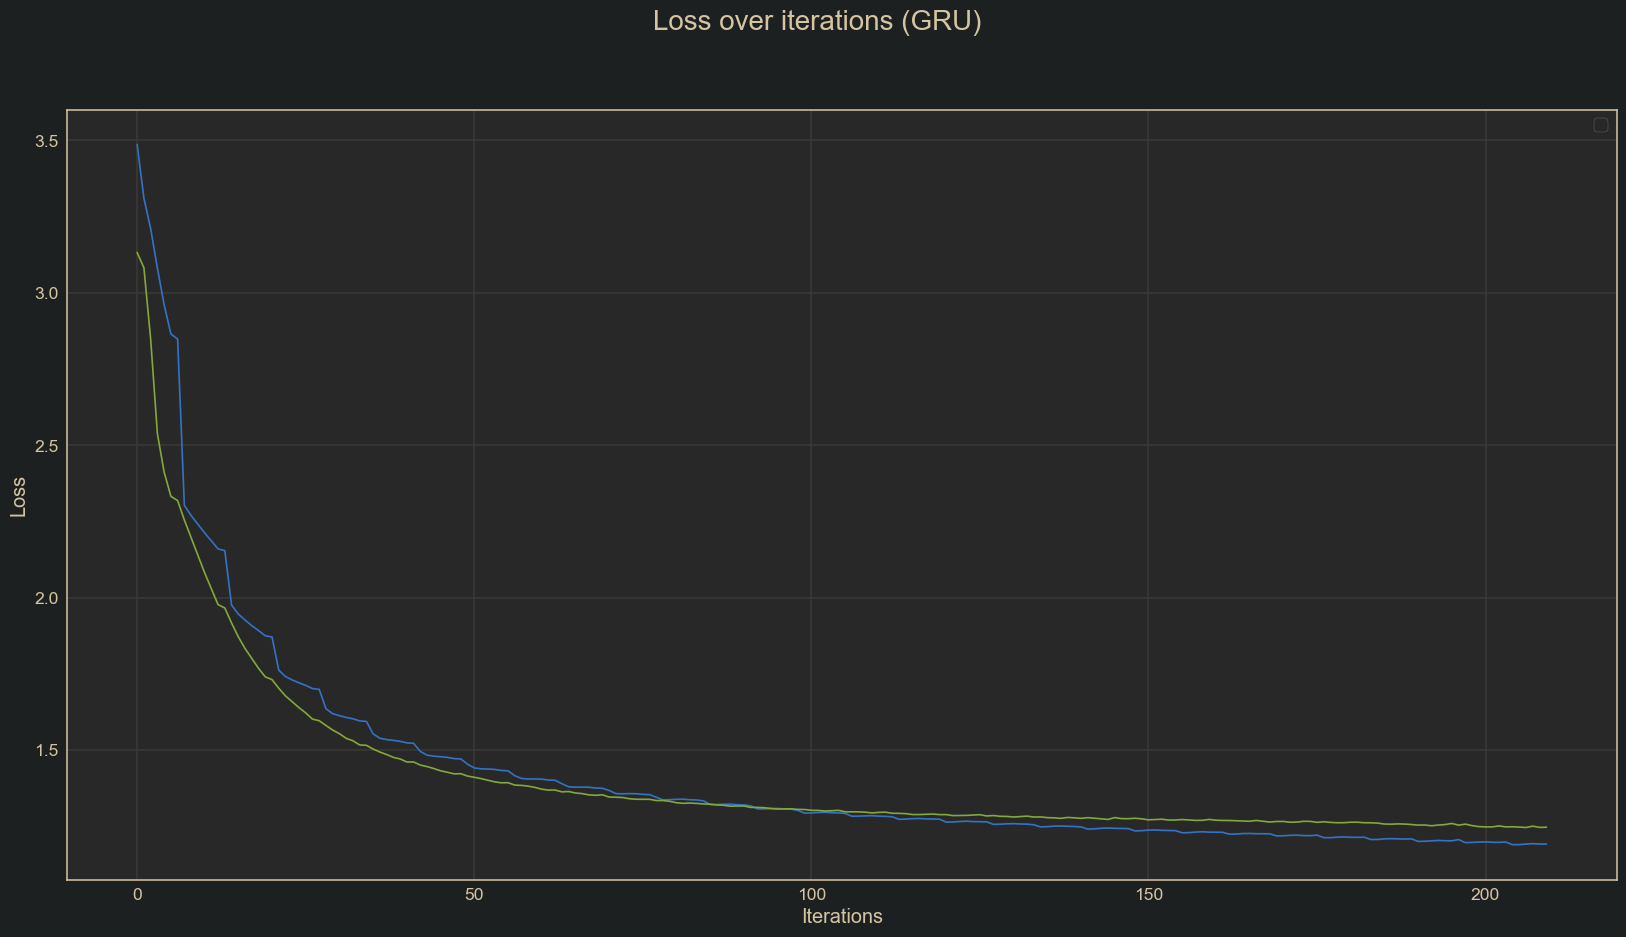

In [49]:
plt.figure(figsize = (20, 10))
plt.plot(range(len(running_train_loss)), running_train_loss, range(len(running_val_loss)), running_val_loss)
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.suptitle("Loss over iterations (GRU)", fontsize = 20)
plt.legend()
plt.show(); plt.close("all")

In [50]:
### Freeze model weights
model.requires_grad_ = False

In [51]:
int2char = encoding_results.int2char
char2int = encoding_results.char2int

In [52]:
seed = "Lan al'Mandragoran went up the mountain"
k = 5

In [53]:
def predict(x, h, net, k = 5):
    x = np.array([[char2int[x]]])
    x = one_hot_encode(x, len(unique_chars))
    x = torch.from_numpy(x).to(device).contiguous()
    
    out, h = net(x, h)
    p = F.softmax(out, dim = -1).data
    p, chars = p.topk(k, dim=-1)
    
    chars = chars.detach().cpu().numpy().squeeze()
    p = p.detach().cpu().numpy().squeeze()
    
    return np.random.choice(chars, p = p/p.sum()), h

In [54]:
h = torch.distributions.Normal(scale = 0.5, loc = 0.).sample((num_layers, 1, hidden_size)).zero_().to(device)
predict("D", h, model, 5)

(76,
 tensor([[[ 0.0912, -0.0772, -0.1242,  ..., -0.0666, -0.0154, -0.0035]],
 
         [[-0.4135,  0.0327,  0.0785,  ..., -0.2408, -0.1371, -0.0066]]],
        device='cuda:0', grad_fn=<CudnnRnnBackward0>))

In [55]:
def prime_model(model, seed, k):
    seed_list = list(seed)

    h = torch.distributions.Normal(scale = 0.5, loc = 0.).sample((num_layers, 1, hidden_size)).to(device)
    if model.base_rnn == nn.LSTM:
        b = torch.distributions.Normal(scale = 0.5, loc = 0.).sample((num_layers, 1, hidden_size))
        h = (h, b.to(device))

    for char in seed_list:
        h = tuple([each.data for each in h]) if type(h) == tuple else h.data
        next_char, h = predict(char, h, model, k)

    seed_list.append(int2char[next_char])

    return seed_list, h

seed_list = list(seed)

h = torch.distributions.Normal(scale = 0.5, loc = 0.).sample((num_layers, 1, hidden_size)).zero_().to(device)

for char in seed_list:
    h = h.data
    next_char, h = predict(char, h, model, k)

seed_list.append(int2char[next_char])
seed_list_1 = seed_list.copy()
seed_list_2 = seed_list.copy()

In [56]:
first_seed_list, h = prime_model(model, seed, k)

In [57]:
print(''.join(first_seed_list))

Lan al'Mandragoran went up the mountain-


In [58]:
## Method 1
for ii in range(1000):
    h = h.data
    next_char, h = predict(first_seed_list[-1], h, model, k)
    first_seed_list.append(int2char[next_char])

In [59]:
seed = "Why would you imagine that"

second_seed_list, h = prime_model(model, seed, k)

In [60]:
## Method 2
for ix in range(1000):
    h = h.data
    x = np.array(char2int[second_seed_list[-1]]).reshape(1, -1)
    x = one_hot_encode(x, len(unique_char))
    x = torch.tensor(x).to(device)
    out, h = model(x, h)
    
    p = F.softmax(out, dim=-1)
    p, chars = p.topk(k = k, dim=-1)
    chars = chars.detach().cpu().numpy().squeeze()
    p = p.detach().cpu().numpy().squeeze()
    second_seed_list.append(int2char[np.random.choice(chars, p = p/p.sum())])
    #next_char = chars[torch.distributions.Uniform(low = 0, high = k).sample().to(torch.int32).item()].item()
    #seed_list.append(int2char[next_char])
    

In [61]:
### First generated text sample
first_pred_text = ''.join(first_seed_list)

In [62]:
print(first_pred_text)

Lan al'Mandragoran went up the mountain-of the country
four all of this suppir cold at his. He could not.... But he was so
machine, and this side. And then the stretched with his
secord white time, and the conversation was intensivity when
he was croading the same termition to a point of her
courage; she felt that this talk about the marshal witheed her to the solitidace of his whole person to the
carriage. His figure had been a couple of his first
tisten, her husband's staracones, and her son, steaping on
his simple, and his heart and her hand on the simple of his
heart which would not be angry. And as though his careful
sensity of his simple care in the meaduwer of the parents.

"That's why it is that it was not a more indiveding. He'll come all about it,"
he recalled her, "that I am! They didn't come and mean in me.

"I shall be of her husband in such a precest
the same. I'm not darting, but you are not an important
principle, but the children, what? They did not know to the people.

In [63]:
### Second generated text sample
second_pred_text = ''.join(second_seed_list)

In [64]:
print(second_pred_text)

Why would you imagine that he had a short hands
in the stern expression in the stand, because he went up,
turned over his studio was to be said, and he said it all at the same time that he would be
strengthening in to him, she said, and seeming from the secure that imagined him,
with a
smile in
her eyes on his happiness.

"Oh, no!" said Stepan Arkadyevitch to her husband and the peasant was
painted by she had said about it, and this however should be
alone, she went out in the drecsinn help of his face to him, started to be
saying the peasants. The same time the paint already wat her hand
and went to the sound of the honor and the servants of
the service and weather of her, said:

"I should have long was a lettoun move house, that's too, the children for
this side of you.... It'll be to be all thing one to be
sure, because I changed that? He's this deticion, and I. If you can't ask him to
me in my secret of that you have to say it to me."

"I am ablo to say, and
then I can't be at the 